# Microsoft Azure AutoML Demo

## Purpose and Challenge

The purpose of this notebook is for the user to build and deploy a Machine Learning (ML) application, starting from scratch.  

The challenge we will tackle is predictive maintenance.  Knowing when critical assets will fail is essential in many business situations.  

In this notebook, we construct and deploy an ML model using Microsoft's new Azure Machine Learning Service.  It will walk you though these steps:

1. [Create Azure Machine Learning Workspace](#Create-Azure-ML-Workspace)
2. [Acquire and Prepare Data](#Acquire-and-Prepare-Data)
3. [Conventional Modeling](#Conventional-Modeling)
4. [Azure AutoML](#Azure-AutoML)
5. [Deploy Model](#Deploy-Model)
6. [Conclusions](#Conclusions)



## Create Azure ML Workspace

Start by creating your [Azure Machine Learning Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/quickstart-get-started)

Then access Microsoft Azure Notebooks ![Microsoft Azure Notebooks](https://docs.microsoft.com/en-us/azure/machine-learning/service/media/quickstart-get-started/explore_ws.png)

## Acquire and Prepare Data

For this notebook, we will use the NASA Prognostics Center's Turbo-Fan Failure dataset.  It is located here: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan

Download and un-zip the data:

In [1]:
# download from url
import urllib
# unzip files
from zipfile import ZipFile

In [2]:
response = urllib.request.urlopen("https://ti.arc.nasa.gov/c/6/")
output = open('CMAPSSData.zip', 'wb')    # note the flag:  "wb"        
output.write(response.read())
output.close()

In [3]:
zipfile = ZipFile("CMAPSSData.zip")
zipfile.extract("train_FD001.txt")

'/home/nbuser/library/train_FD001.txt'

Next we read our data into a Pandas DataFrame.  Note the headers were not in the space seperated txt file, so we assign them from the ReadMe in the zip file.  In pandas we use read_csv with the delimiter option, even with a space delimited file.

In [4]:
%matplotlib inline
# plotting package
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
# dataframe package
import pandas as pd

In [5]:
train = pd.read_csv("train_FD001.txt", delimiter=" ", index_col=None, names=['unit','cycle','os1','os2','os3','sm1','sm2','sm3','sm4','sm5','sm6','sm7','sm8','sm9','sm10','sm11','sm12','sm13','sm14','sm15','sm16','sm17','sm18','sm19','sm20','sm21','sm22','sm23'])

Take a quick look at the data

In [6]:
train.head(5)

,unit,cycle,os1,os2,os3,sm1,sm2,sm3,sm4,sm5,...,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21,sm22,sm23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


Our dataset has a number of units in it, with each engine flight listed as a cycle.  The cycles count up until the engine fails.  What we would like to solve for is the cycles until failure, so we need to calculate a new column called rul, or Remaining Useful Life.  It will be the last cycle value minus each cycle value per unit.

In [7]:
# Assign ground truth
def assignrul(df):
    maxi = df['cycle'].max()
    df['rul'] = maxi - df['cycle']
    return df
    

train1 = train.groupby('unit').apply(assignrul)

train1.columns

Index(['unit', 'cycle', 'os1', 'os2', 'os3', 'sm1', 'sm2', 'sm3', 'sm4', 'sm5',
       'sm6', 'sm7', 'sm8', 'sm9', 'sm10', 'sm11', 'sm12', 'sm13', 'sm14',
       'sm15', 'sm16', 'sm17', 'sm18', 'sm19', 'sm20', 'sm21', 'sm22', 'sm23',
       'rul'],
      dtype='object')

Now our dataframe has the 'rul' column.  Predicting this value will be the objective of the model.  

In [8]:
train1.head(5)

,unit,cycle,os1,os2,os3,sm1,sm2,sm3,sm4,sm5,...,sm15,sm16,sm17,sm18,sm19,sm20,sm21,sm22,sm23,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,187


Let's take a quick visualization of the data.  Note that as we approach 

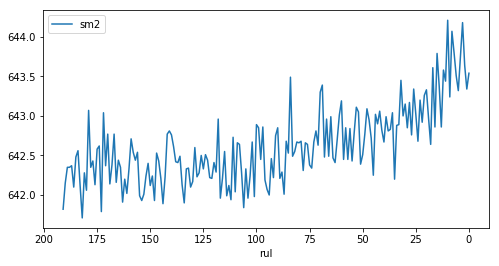

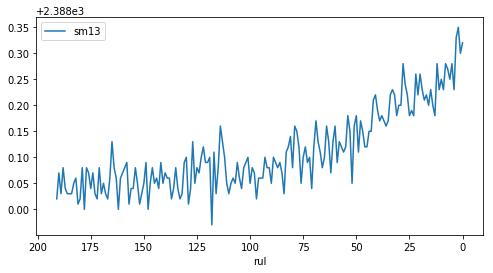

In [9]:
train1[train1['unit']==1].plot(x='rul', y='sm2', figsize=(8,4)).invert_xaxis()
train1[train1['unit']==1].plot(x='rul', y='sm13', figsize=(8,4)).invert_xaxis()

First note that the sensor measurements do seem to be changing as we near 0 rul.  This implies that we should be able to make a model that will be useful enough for business value.

Also note that the data is noisy and the scales are vastly different.  This implies that noise reduction and re-scaling techniques should improve model performance.  Noise reduction is out of scope for this notebook. 

As in the two sensors above, but there is many sensor measurements that are co-linear.  This also can cause issues with regression.  Addressing this will be out of scope for this notebook.

We are now ready to train a model on this data.

## Conventional Modeling

We start by training a simple model for comparison to Azure's AutoML.  We will use simple OLS linear regression from a well-known statistics package for python.  Linear regression assumes that a linear combination of sensor measurements can be used to predict rul.  This model should weakly fit the data, giving a floor for accuracy and a benchmark for modeling improvements.

In [10]:
# linear regression model
from statsmodels.formula.api import ols
# accuracy metrics
import sklearn.metrics as skl

In [11]:
# train the model
ols5 = ols("rul ~ sm3 + sm4 + sm7 + sm8 + sm9 + sm11 + sm12 + sm13 + sm14 + sm15 + sm17 + sm20 + sm21", train1).fit()
# view summary output
ols5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rul   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     2177.
Date:                Tue, 20 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:41:57   Log-Likelihood:            -1.0768e+05
No. Observations:               20631   AIC:                         2.154e+05
Df Residuals:                   20617   BIC:                         2.155e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.168e+04   2.82e+04      2.895      0.004    2.64e+04    1.37e+05
sm3           -0.4582      0.077     -5.966      0.000      -0.609      -0.308
sm4           -0.7993      0.074    -10.822      0.000      -0.944      -0.655
sm7            7.1580      0.731      9.791      0.000       5.725       8.591
sm8          -17.7824      9.500     -1.872      0.061     -36.403       0.839
sm9           -0.3617      0.060     -6.073      0.000      -0.478      -0.245
sm11         -39.1752      2.842    -13.784      0.000     -44.746     -33.605
sm12          11.2009      0.965     11.602      0.000       9.308      13.093
sm13         -16.5978      9.365     -1.772      0.076     -34.954       1.758
sm14          -0.2766      0.068     -4.078      0.000      -0.409      -0.144
sm15        -125.7525     15.054     -8.353      0.000    -155.259     -96.246
sm17          -1.9557      0.321     -6.086      0.000      -2.586      -1.326
sm20          20.8537      3.011      6.925      0.000      14.951      26.756
sm21          43.0922      5.063      8.511      0.000      33.168      53.017
==============================================================================
Omnibus:                     3243.041   Durbin-Watson:                   0.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5670.484
Skew:                           1.025   Prob(JB):                         0.00
Kurtosis:                       4.547   Cond. No.                     1.16e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

To illustrate the co-linearity issues, note that if we eliminate sm8 and sm13, our Adjusted R-squared does not change.  R-squared is defined as the percentage of rul that the model can explain.

Also note that we will be using training error to evaluate our models.  There is a test set included in the zip file, but test accuracy is out of scope for this notebook.

In [12]:
# train the model
ols5 = ols("rul ~ sm3 + sm4 + sm7 + sm9 + sm11 + sm12 + sm14 + sm15 + sm17 + sm20 + sm21", train1).fit()
# view summary output
ols5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rul   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     2571.
Date:                Tue, 20 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:41:57   Log-Likelihood:            -1.0768e+05
No. Observations:               20631   AIC:                         2.154e+05
Df Residuals:                   20619   BIC:                         2.155e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1076.5404    711.124     -1.514      0.130   -2470.400     317.319
sm3           -0.4780      0.077     -6.247      0.000      -0.628      -0.328
sm4           -0.8370      0.073    -11.506      0.000      -0.980      -0.694
sm7            7.5486      0.719     10.499      0.000       6.139       8.958
sm9           -0.3558      0.060     -5.978      0.000      -0.473      -0.239
sm11         -40.9720      2.776    -14.761      0.000     -46.413     -35.531
sm12          11.7463      0.947     12.398      0.000       9.889      13.603
sm14          -0.2430      0.067     -3.635      0.000      -0.374      -0.112
sm15        -131.7309     14.918     -8.831      0.000    -160.971    -102.491
sm17          -2.0581      0.319     -6.442      0.000      -2.684      -1.432
sm20          21.8623      2.992      7.306      0.000      15.997      27.727
sm21          44.9787      5.023      8.954      0.000      35.133      54.824
==============================================================================
Omnibus:                     3224.855   Durbin-Watson:                   0.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5632.968
Skew:                           1.021   Prob(JB):                         0.00
Kurtosis:                       4.545   Cond. No.                     2.83e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Azure AutoML

    Here we utilize Azure's AutoML package to automate the scaling of the sensors, selection of sensors, and automatically train and evaluate many different types of ML models.

In [13]:
import azureml
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.widgets import RunDetails
from azureml.core.model import Model
print(azureml.core.VERSION)

0.1.74


You need to supply information on your ML Workspace to run AutoML.  You will need to perform Microsoft's MFA.  This can be accomplished from any computer.  You just need to click on the link and enter the code provided.

In [14]:
ws = Workspace(subscription_id="f0189cd7-f120-4033-a775-847cb36fe5a3", resource_group="pmamlrg", workspace_name="pmamldemo")

In [15]:
# setup for experiment
project_folder = './sample_projects/pmamldremo'
experiment_name = 'pmamldemo2'

In [16]:
# put training data into X and Y arrays
X_train = train1.iloc[:,2:26].values
y_train = train1.iloc[:,28:29].values.astype(int).flatten()

We format our data into arrays that AutoML will use to train models.  Below is one row of X and Y as an example.

In [17]:
X_train[0]

array([-7.00000e-04, -4.00000e-04,  1.00000e+02,  5.18670e+02,
        6.41820e+02,  1.58970e+03,  1.40060e+03,  1.46200e+01,
        2.16100e+01,  5.54360e+02,  2.38806e+03,  9.04619e+03,
        1.30000e+00,  4.74700e+01,  5.21660e+02,  2.38802e+03,
        8.13862e+03,  8.41950e+00,  3.00000e-02,  3.92000e+02,
        2.38800e+03,  1.00000e+02,  3.90600e+01,  2.34190e+01])

In [18]:
y_train[0]

191

Now we are ready to configure Azure AutoML.  We give it information on what we want to predict, what accuracy metric we want to use, how many models we want to try, and many other parameters.  We will start with 8 different models that AutoML will chose.  AutoML will also automatically scale the data for us.

In [19]:
##Local compute 
Automl_config = AutoMLConfig(task = 'regression',
                             primary_metric = 'r2_score',
                             max_time_sec = 120,
                             iterations = 8,
                             n_cross_validations = 3,
                             preprocess = False,
                             exit_score = 0.985,
                             blacklist_algos = ['kNN','LinearSVM'],
                             X = X_train,
                             y = y_train,
                             path=project_folder)

Finally we are ready to launch AutoML.  This step can take many minutes, but AutoML will give you updates as models are trained and evaluated by the metric we specified above.  AutoML also let us know which scaling method was used.  The information from each ML model training will be stored in the Experiment section of the ML Workspace, where we can review it through Azure Portal.

In [20]:
# Train multiple models using AutoML
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(Automl_config, show_output=True)

Parent Run ID: AutoML_8b62de79-7890-43f9-a688-7fa0530d2e5e
***********************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************************************************************************

 ITERATION     PIPELINE                               DURATION                METRIC      BEST
         0                                            0:02:07.386320             nan       nan
ERROR: Parent run 'AutoML_8b62de79-7890-43f9-a688-7fa0530d2e5e' failed. Check automl.log for more details.
         1      RobustScaler ElasticNet               0:00:31.245826           0.568     0.568
         2      RobustScaler ElasticNet               0:00:32.861112           0.568     0.568
    

In [21]:
RunDetails(local_run).show()
#local_run.get_details()

_AutoML(widget_settings={'childWidgetDisplay': 'popup'})

Note that many (but not all) of the models beat our baseline linear regression model.  We want to keep the best model and deploy it as a service.

In [ ]:
# find the run with the highest accuracy value.
best_run, fitted_model = local_run.get_output()
print(best_run)

In [23]:
# register model in workspace
description = 'AutoML RUL Regression 20181116'
tags = None
local_run.register_model(description=description, tags=tags)
local_run.model_id # Use this id to deploy the model as a web service in Azure

Registering model AutoML8b62de797best


'AutoML8b62de797best'

## Deploy Model

After we register the model in our ML Workspace, it should be visible in Azure Portal.  This is easy to check.

Now we want to deploy the model as a REST API that we can feed a row or rows of "X" data to, and return the predicted 'rul' value.  To accomplish this, we will build a container image in our ML Workspace and deploy that image as a Container instance in Azure's ACI service.  We will then obtain an IP address where we can submit data and receive back the predicted 'rul' value.

There are 3 things we need: 
1. A score.py file that contains the init() and run() functions with instructions on how to load and socre with the model
2. A myenv.yml file that contains information on the python environment in which the model needs to run
3. Configurations for our images and our services, using functions provided by AzureML service.

The cells below help you set these up.   You will need to use the registered model name provided by the cell above.

In [33]:
%%writefile score.py
# Scoring Script
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retreive the path to the model file using the model name
    model_path = Model.get_model_path('AutoML8b62de797best')
    print(model_path)
    model = joblib.load(model_path)
    

def run(raw_data):
    # grab and prepare the data
    data = (np.array(json.loads(raw_data)['data'])).reshape(1,-1)
    # make prediction
    y_hat = model.predict(data)
    return json.dumps(y_hat.tolist())

Overwriting score.py


In [34]:
# Env File
from azureml.core.conda_dependencies import CondaDependencies 

cd = CondaDependencies()

# Temporary workaround to Docker build issue
cd.add_pip_package("pynacl==1.2.1")
cd.add_pip_package("azureml-sdk[automl]")
cd.add_conda_package("scikit-learn=0.19.1")

cd.save_to_file(".", "myenv.yml")

'myenv.yml'

Now configure the webservice.

In [35]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "RUL",  "method" : "sklearn"}, 
                                               description='Predict RUL with Azure AutoML')

Finally, we configure the container image and deploy the service.  You will need to make sure the filenames match, your Workspace is in variable ws, and your model name is correct.  It will create your containter image and deploy it as a webservice.

This process can take up to 10 minutes, so please be patient.  There is a progress bar.

In [36]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

# configure the image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="myenv.yml")

service = Webservice.deploy_from_model(workspace=ws,
                                       name='automl-rul-regression-14',
                                       deployment_config=aciconfig,
                                       models=['AutoML8b62de797best:1'],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)

Creating image
Image creation operation finished for image automl-rul-regression-14:1, operation "Succeeded"
Creating service
Running..................................
SucceededACI service creation operation finished, operation "Succeeded"
CPU times: user 8.6 s, sys: 445 ms, total: 9.05 s
Wall time: 7min 19s


Just as a check, we can retrieve the URI for the scoring function.  This is what customers will use to access the model.

In [37]:
print(service.scoring_uri)

http://40.114.37.133:80/score


Let's check to see if the service is working.  Here we submit a single row of data from X_train to see if it returns a reasonable prediction.

In [38]:
import requests
import json

# send a random row from the test set to score
#random_index = np.random.randint(0, len(X_train)-1)
input_data = "{\"data\": " + str(list(X_train[0].reshape(1,-1)[0])) + "}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
print("input data:", input_data)
print("label:", y_train[0:1])
print("prediction:", resp.text)

POST to url http://40.114.37.133:80/score
input data: {"data": [-0.0007, -0.0004, 100.0, 518.67, 641.82, 1589.7, 1400.6, 14.62, 21.61, 554.36, 2388.06, 9046.19, 1.3, 47.47, 521.66, 2388.02, 8138.62, 8.4195, 0.03, 392.0, 2388.0, 100.0, 39.06, 23.419]}
label: [191]
prediction: "[156.79257735314243]"


Let's take a look at what the output looks like.  We plot predicted rul vs. actual rul for one engine.

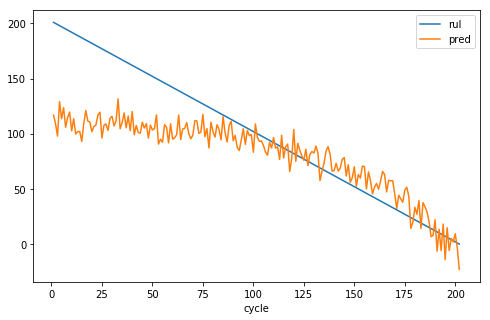

In [39]:
# score model
train1['pred'] = ols5.predict().transpose()

# visualize
train1[train1['unit']==22].plot(x='cycle', y=['rul','pred'], figsize=(8,5))


Here we see one engine evolving through many flights, or cycles.  As we approach failure, the rul declines to zero, as does the prediction.  This is a good example of how the predictive model can assist in estimate the future failure of the engine.

Note that the model does not perform well at high rul.  This is an acceptable outcome as the engine is far from failure.

To avoid any run-away Azure costs, we always delete un-necessary services when we are done.

In [26]:
service.delete()

## Conclusions

We have executed an end-to-end Azure ML Services project using a value-providing demonstration dataset.  This notebook starts with a blank slate and proceeds to create the Azure ML Workspace, download a predictive maintenance dataset, process the data, build a baseline model, train a more sophisticated model with Azure AutoML, and deploy that model quickly and easily using Azure's ML Workspace.   